# Pelican Data Extract and 3D Velocity Calculations
*Eric G. Suchanek, Ph.D. 3/15/19*

This code performs a Gaia rectangular search from 20h50m18s, 44d13m30s to 20h51m22s 44d25m0s and extracts:
* ra, dec, pmra, pmdec, pmra_error, pmdec_error, parallax, parallax_error, g_mean_mag

The Radial_velocities were generally unavailable. No variability data was available either for this query. As a result I changed the query to not pull these fields. 3d velocities were calculated per the formulae discussed in: http://www.astronexus.com/a-a/motions-long-term. These values were then written out to a csv file containing the query results.

In [6]:
#
# Setup the libraries. 

import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import Latitude, Longitude, Angle, SkyCoord
from astropy.visualization import astropy_mpl_style
from astropy.io import ascii
from astroquery.gaia import Gaia

import numpy as np
import time

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from pandas import read_csv
%matplotlib inline

# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

# only pull non-null parallax, pmra, and pmdec

sel_str_box = "SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),BOX('ICRS',{},{},{},{}))=1 \
AND gaia_source.parallax IS NOT NULL \
AND gaia_source.pmra IS NOT NULL \
AND gaia_source.pmdec IS NOT NULL ;"

sel_str_box_all = "SELECT * \
FROM gaiadr2.gaia_source  \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),BOX('ICRS',{},{},{},{}))=1 ;"

sel_str_circle = "SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',{},{},{}))=1 \
AND abs(pmra_error/pmra)<{} \
AND abs(pmdec_error/pmdec)<{} \
AND pmra IS NOT NULL AND abs(pmra)>0 \
AND pmdec IS NOT NULL AND abs(pmdec)>0;"

sel_str_circle_all = "SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',{},{},{}))=1;"


# from: http://www.astronexus.com/a-a/motions-long-term
def compute_3d_velocities(ra, dec, pmra, pmdec, parallax):
    dist = 1.0 / parallax
    # transverse distances in km/sec
    vtA = dist * pmra * 4.74
    vtD = dist * pmdec * 4.74
    vR = 0.0
    """
    Get Cartesian velocity coordinates vx, vy, and vz in terms of the three velocities 
    vR, vTA, and vTD. Here are the equations to do this:

    vx = (vR cos \delta cos \alpha) - (vTA sin \alpha) - (vTD sin \delta cos \alpha)
    vy = (vR cos \delta sin \alpha) + (vTA cos \alpha) - (vTD sin \delta sin \alpha)
    vz = vR sin \delta + vTD cos \delta
    """
    # since we don't have radial velocities in general we ignore the first term above
    # note that we use the .rad value for trig functions.
    
    vx = (vR * np.cos(dec.rad) * np.cos(ra.rad)) - (vtA * np.sin(ra.rad)) - (vtD * np.sin(dec.rad) * np.cos(ra.rad))
    vy = (vR * np.cos(dec.rad) * np.sin(ra.rad)) + (vtA * np.cos(ra.rad)) - (vtD * np.sin(dec.rad) * np.sin(ra.rad))
    vz = vR * np.sin(dec.rad) + vtD * np.cos(dec.rad)
    return(vx, vy, vz)
#

# returns in pc/yr
def compute_3d_velocities_pc(ra, dec, pmra, pmdec, parallax):
    dist = 1.0 / parallax
    # transverse distances in km/sec
    vtA = dist * pmra * 4.74
    vtD = dist * pmdec * 4.74
    vR = 0.0
    
    """
    Get Cartesian velocity coordinates vx, vy, and vz in terms of the three velocities 
    vR, vTA, and vTD. Here are the equations to do this:

    vx = (vR cos \delta cos \alpha) - (vTA sin \alpha) - (vTD sin \delta cos \alpha)
    vy = (vR cos \delta sin \alpha) + (vTA cos \alpha) - (vTD sin \delta sin \alpha)
    vz = vR sin \delta + vTD cos \delta
    """
    # since we don't have radial velocities in general we ignore the first term above
    # note that we use the .rad value for trig functions.
    # convert to pc/yr
    
    vx = ((vR * np.cos(dec.rad) * np.cos(ra.rad)) - (vtA * np.sin(ra.rad)) - (vtD * np.sin(dec.rad) * np.cos(ra.rad))) / 977780.0
    vy = ((vR * np.cos(dec.rad) * np.sin(ra.rad)) + (vtA * np.cos(ra.rad)) - (vtD * np.sin(dec.rad) * np.sin(ra.rad))) / 977780.0
    vz = (vR * np.sin(dec.rad) + vtD * np.cos(dec.rad)) / 977780.0

    return(vx, vy, vz)

# compute proper motion angle, return in degrees, correct for quadrant
def compute_pm_angles(stars):
    def cart2ang(x, y):
        # rho = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y, x)
        phi *= 180.0 / np.pi # to degrees
        if y < 0.0:
            phi += 180.0
        return(phi)

    tot = len(stars)
    ang = [0.0] * tot
    
    for i in range(tot):
        ang[i] = cart2ang(stars[i]['pmra'],stars[i]['pmdec'])
    return(ang)
#

# Bruce's search parameters
_ra1 = "20h50m18s"
_dec1 = "44d13m30s"

_ra2 = "20h51m22s"
_dec2 = "44d25m0s"
                                                                                                                
# this will do the math to calculate the angular
# width of the query box
ra1 = Longitude(_ra1,unit=u.hourangle)
ra2 = Longitude(_ra2, unit=u.hourangle)

dec1 = Latitude(_dec1,unit=u.degree)
dec2 = Latitude(_dec2,unit=u.degree)

ra_diff = ra2 - ra1
dec_diff = dec2 - dec1 

delta_ra = ra_diff / 2.0
delta_dec = dec_diff / 2.0

ra_center = ra1 + delta_ra
dec_center = dec1 + delta_dec

# print(ra_center.deg, dec_center.deg, ra_diff.deg, dec_diff.deg)

position_string = _ra1 + " " + _dec1 + ", " + _ra2 + " " + _dec2 + " " + str(ra_diff) + " x " + str(dec_diff)
#print(position_string)
position_string_center = "Center: " + str(ra_center) + ", " + str(dec_center) + " (" + str(delta_ra) + " x " + str(delta_dec) + ")"
print(position_string_center)

project_name = "PelPM_"
data_filename = project_name + _ra1 + "_" + _dec1 + "_.csv"
vel_filename = project_name + _ra1 + "_" + _dec1 + "_vel_out.csv"

# 312.708333,44.3208333,0.2666667,0.1966667 from gaia query

query_str = str.format(sel_str_box,ra_center.deg, dec_center.deg, ra_diff.deg, dec_diff.deg)

job = Gaia.launch_job_async(query=query_str, dump_to_file=True, 
                            output_file=data_filename, output_format='csv')
stars = job.get_results()
star_count = len(stars)  # global variable

# all in mas, convert to arcsecs
pmra = stars['pmra'] / 1000.0
pmdec = stars['pmdec'] / 1000.0
parallax = stars['parallax'] / 1000.0

# convert to long and lat to get the units right
ra = Longitude(stars['ra'],unit=u.deg)
dec = Latitude(stars['dec'],unit=u.deg)

print(str.format("Returned: {} stars", star_count))
# velocities
vx = []
vy = []
vz = []

# compute the velocity vectors
vx, vy, vz = compute_3d_velocities_pc(ra, dec, pmra, pmdec, parallax)
data = read_csv(data_filename)

# add new columns to the data for velocities
data['VX (pc/yr)'] = vx
data['VY (pc/yr)'] = vy
data['VZ (pc/yr)'] = vz

# write the file
data.to_csv(vel_filename)
print('Done.')


Center: 20h50m50s, 44d19m15s (0h00m32s x 0d05m45s)
Returned: 893 stars
Done.


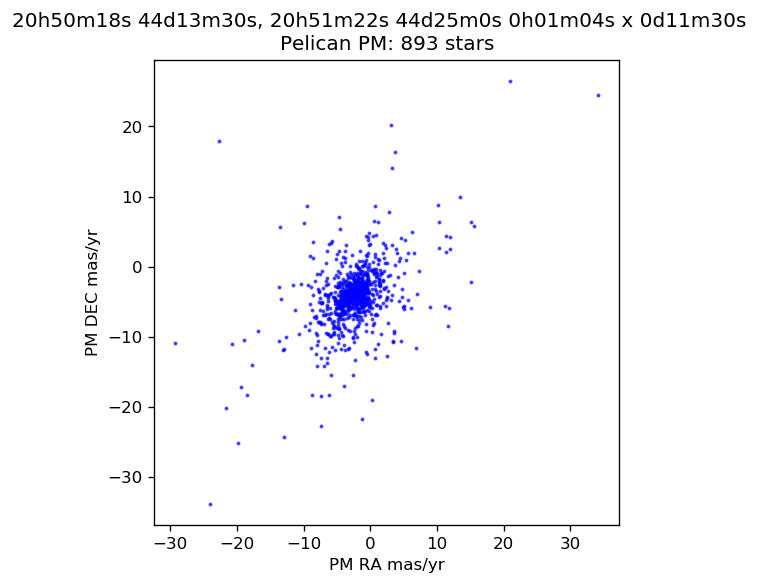

In [7]:
# scatter plot
fig, ax = plt.subplots(figsize=(5,5),dpi=120)

ax.scatter(stars['pmra'], stars['pmdec'], color='b', alpha=0.6, s=2)

fig.subplots_adjust(top=0.90)
plt.title('Pelican PM: ' + str(len(stars))+ ' stars')
plt.suptitle(position_string)
# ax.set_title('axes title')
ax.set_xlabel('PM RA mas/yr')
ax.set_ylabel('PM DEC mas/yr')

plt.show()
plt.close()

#
# Create a histogram plot of the stars, showing the distribution of the 
# PM angle
#

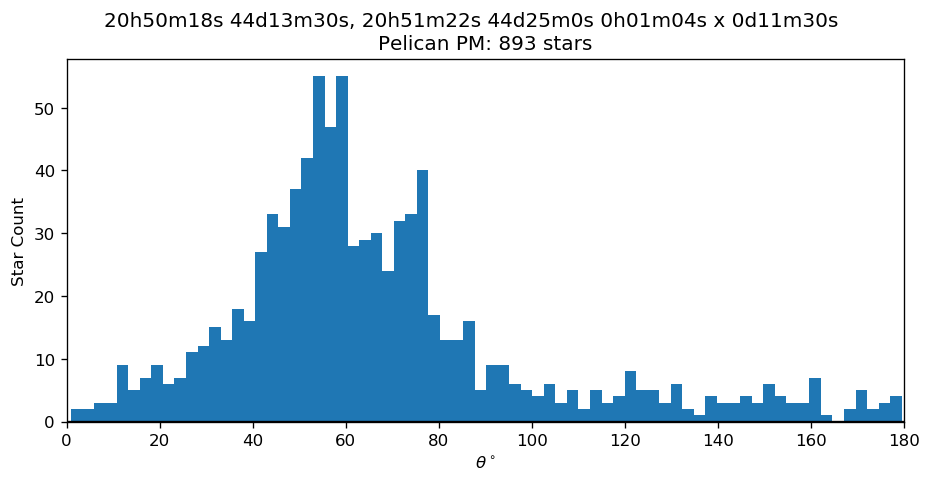

In [8]:
# Plot histograms for the PM Errors
n_bins = 72
plt_title = "PM Analysis (BW Query) "

fig, ax1 = plt.subplots(sharey=False,figsize=(9,4), dpi=120)

fig.suptitle(plt_title + str(star_count)+ ' stars',fontsize=12)

plt.title('Pelican PM: ' + str(len(stars))+ ' stars')
plt.suptitle(position_string)

ax1.set_xlabel(r"$\theta^\circ$")
ax1.set_ylabel('Star Count')
ax1.set_xlim(left=0,right=180)
ax1.grid(False)
ax1.axhline(0, color='black', lw=2)

x = []
x = compute_pm_angles(stars)

ax1.hist(x, bins=n_bins)

plt.show()


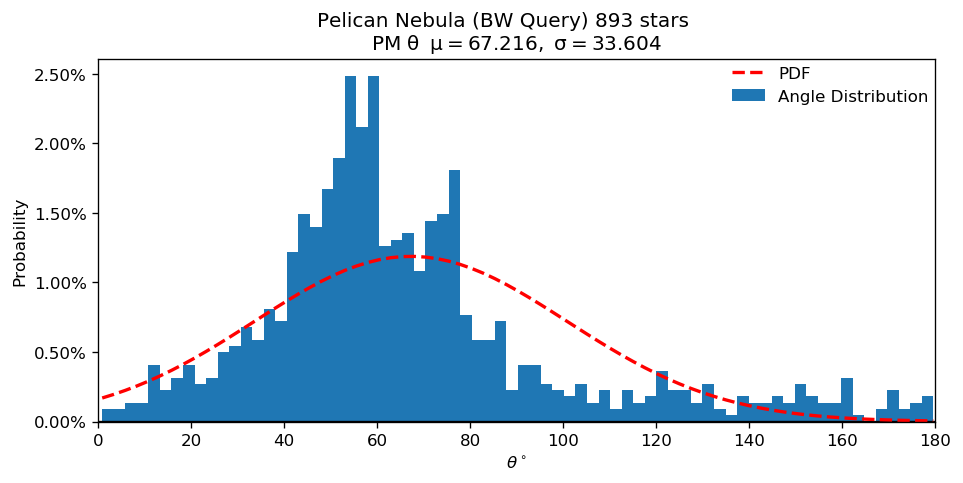

In [9]:
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Plot probability histograms for the PM Errors
# https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.norm.html
#

n_bins = 72
plt_title = "Pelican Nebula (BW Query) "

fig, ax = plt.subplots(sharey=False,figsize=(9,4), dpi=120)
fig.suptitle(plt_title + str(star_count)+ ' stars',fontsize=12)
#plt.title(r'$\mathrm{PM\ \theta\ PDF \ fit:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))

ax.set_xlabel(r"$\theta^\circ$")
ax.set_ylabel('Probability')
ax.set_xlim(left=0,right=180)
ax.grid(False)
ax.axhline(0, color='black', lw=2)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))  

#'$\mathrm \exp(-x^{2/2})/\sqrt{(2*\pi)}'
#dens_str = "$\mathrm (-x^{2/2})/\sqrt{(2*\pi)}$"
dens_str = "PDF fit"


angles = []
angles = compute_pm_angles(stars)

# get rough parameter estimates 
(mu, sigma ) = norm.fit(angles)

#mean, var, skew, kurt = norm.stats(moments='mvsk')
# note that this freezes the histogram. 

n, bins, patches = ax.hist(angles, bins=n_bins, density=True, label='Angle Distribution')

# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)

l, = plt.plot(bins, y, 'r--', linewidth=2, label = "PDF")

#ax.plot(bins, norm.pdf(y),'r--', linewidth=2, label = "$ e^{-x^2/2} / \sqrt{(2*\pi)}$")

plt.title(r'$\mathrm{PM\ \theta\: \ \mu=%.3f,\ \sigma=%.3f}$' %(mu, sigma))
plt.legend(loc='best',frameon=False, borderaxespad=0.)
plt.show()


In [10]:
#ipywidgets-display::
# Parallax 3D Quiver
import ipyvolume as ipv
import numpy as np
from ipywidgets import FloatSlider, ColorPicker, VBox, jslink

# returns the extents of each input vector shunk by sh (decimal percent)
def myshrink(X,Y,Z,sh):
    xmin = np.min(X)
    xmax = np.max(X)
    ymin = np.min(Y)
    ymax = np.max(Y)
    zmin = np.min(Z)
    zmax = np.max(Z)
    zmin2 = zmin - sh * zmin
    zmax2 = zmax + sh * zmax
    xmin2 = xmin - sh * xmin
    xmax2 = xmax + sh * xmax
    ymin2 = ymin + sh * ymax
    ymax2 = ymax + sh * ymax
    
    return xmin,xmax,ymin,ymax,zmin,zmax

X = stars['ra']
Y = stars['dec']
Z = stars['parallax']

pmra = stars['pmra']
pmdec = stars['pmdec']
parallax = stars['parallax']

# velocities
vx = []
vy = []
vz = []

# compute the velocity vectors
vx, vy, vz = compute_3d_velocities_pc(ra,dec,pmra,pmdec,parallax)
scale = 10
vx *= scale
vy *= scale
vz *= scale


_figwidth = 600
_figheight = 600

sh = .05 # percentage to shrink the min/max - the plot fails unless we do this
xmin,xmax,ymin,ymax,zmin,zmax = myshrink(X, Y, Z, sh)

# 3d quiver with ipyvolume
ipv.clear()
ipv.figure(width=_figwidth,height=_figheight)
ipv.xyzlabel('RA','Dec', 'Parallax')
ipv.style.use("dark")

quiv = ipv.quiver(X,Y,Z,vx,vy,vz,size=4,size_selected=8)
ipv.xlim(xmin,xmax)
ipv.ylim(ymin,ymax)
#ipv.zlim(zmin,zmax)
ipv.zlim(-5.0,5.0)

selected = []
size = FloatSlider(min=0, max=30, step=0.1)
size_selected = FloatSlider(min=0, max=30, step=0.1)
color = ColorPicker()
color_selected = ColorPicker()

para_min = FloatSlider(min=zmin,max=zmax,step=0.1)
para_max = FloatSlider(min=zmin,max=zmax,step=0.1)

jslink((quiv, 'size'), (size, 'value'))
jslink((quiv, 'color'), (color, 'value'))

#ipv.animation_control(quiv, interval=10)
VBox([ipv.gcc(), size, color])